In [1]:
#importowanie bibliotek
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, LabelEncoder
from nltk.stem.porter import PorterStemmer
import nltk
from nltk.corpus import stopwords
import re
import string
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv("PreProcessedData.csv")

In [3]:
df = df.sample(frac=0.5) #zeby szybciej sie uczylo, potem wezmiemy calosc

In [4]:
df.head()

,Unnamed: 0,title,text,Ground Label
44755,44755,"Hecklers disrupt Trump rally, photographer sho...",WASHINGTON - A Donald Trump rally in Virginia ...,true
9675,9675,"BREAKING: WOMEN, MEN ARRESTED After MAJOR BRAW...",The moral decay of our nation continues full s...,fake
4274,4274,OBAMA’S BAILOUT OF PUERTO RICO: TAXPAYERS Take...,Puerto Rico is getting a HUGE bailout from the...,fake
649,649,‘A DELIRIUM IS SPREADING’ – The Left’s Great R...,The very people who for years talked about th...,fake
14658,14658,"6.3 earthquake, Central Italy! (earlier was M5.6)","6.3 earthquake, Central Italy! (earlier was M5...",fake


In [5]:
df.rename(columns = {'Ground Label': 'label'},inplace=True)

In [6]:
#usunm ta jedna kolumne bo jest useless
df.drop(df.columns[0], inplace=True, axis=1)

In [7]:
df.head()

,title,text,label
44755,"Hecklers disrupt Trump rally, photographer sho...",WASHINGTON - A Donald Trump rally in Virginia ...,true
9675,"BREAKING: WOMEN, MEN ARRESTED After MAJOR BRAW...",The moral decay of our nation continues full s...,fake
4274,OBAMA’S BAILOUT OF PUERTO RICO: TAXPAYERS Take...,Puerto Rico is getting a HUGE bailout from the...,fake
649,‘A DELIRIUM IS SPREADING’ – The Left’s Great R...,The very people who for years talked about th...,fake
14658,"6.3 earthquake, Central Italy! (earlier was M5.6)","6.3 earthquake, Central Italy! (earlier was M5...",fake


# 1. Analiza całokształtu zadania - CEL

In [8]:
#Cel: mamy title newsa, text i ground label czyli informacje czy to jest fake czy nie -> 
#musimy stworzyc model klasyfikacji ktory bedzie to stwierdzac

In [9]:
# TODO => TRZEBA ZROBIC PIPELINE!

# 2. Wizualizacja danych

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34522 entries, 44755 to 45070
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   34183 non-null  object
 1   text    34492 non-null  object
 2   label   34522 non-null  object
dtypes: object(3)
memory usage: 1.1+ MB


In [11]:
df.shape

(34522, 3)

In [12]:
df['label'].value_counts()

fake    21243
true    13279
Name: label, dtype: int64

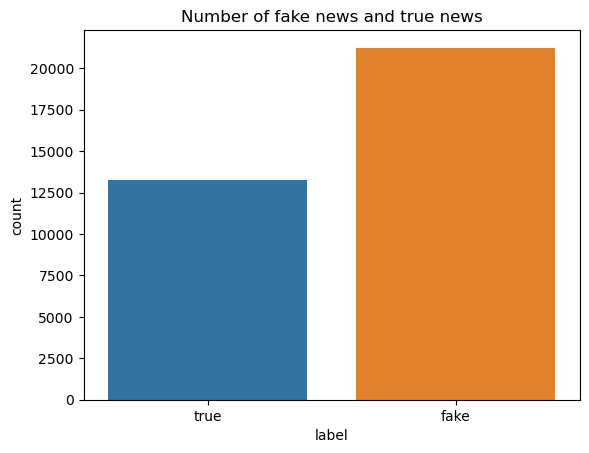

In [13]:
sns.countplot(df['label'])
plt.title('Number of fake news and true news')
plt.show()

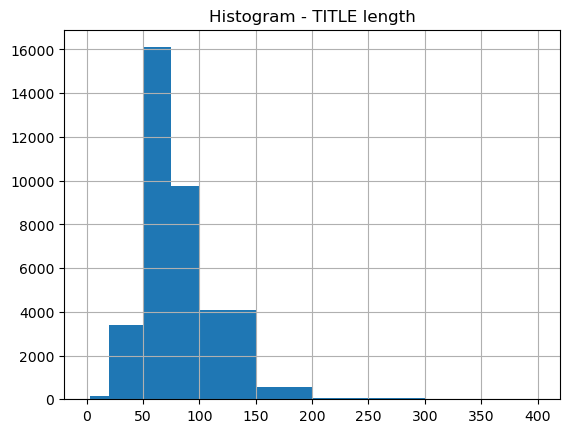

In [14]:
df['title'].str.len().hist(bins=[0,3,20,50,75,100,150,200,300,400])
plt.title('Histogram - TITLE length')
plt.show()

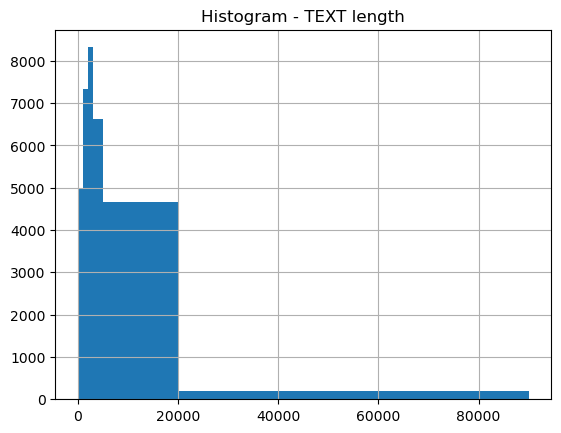

In [15]:
df['text'].str.len().hist(bins=[0,50,200,300,1000,2000,3000,5000,20000,90000])
plt.title('Histogram - TEXT length')
plt.show()

In [16]:
df.isna().sum() #te co nie maja tekstu - usunmy najlepiej, a tytulu doklejmy do textu

title    339
text      30
label      0
dtype: int64

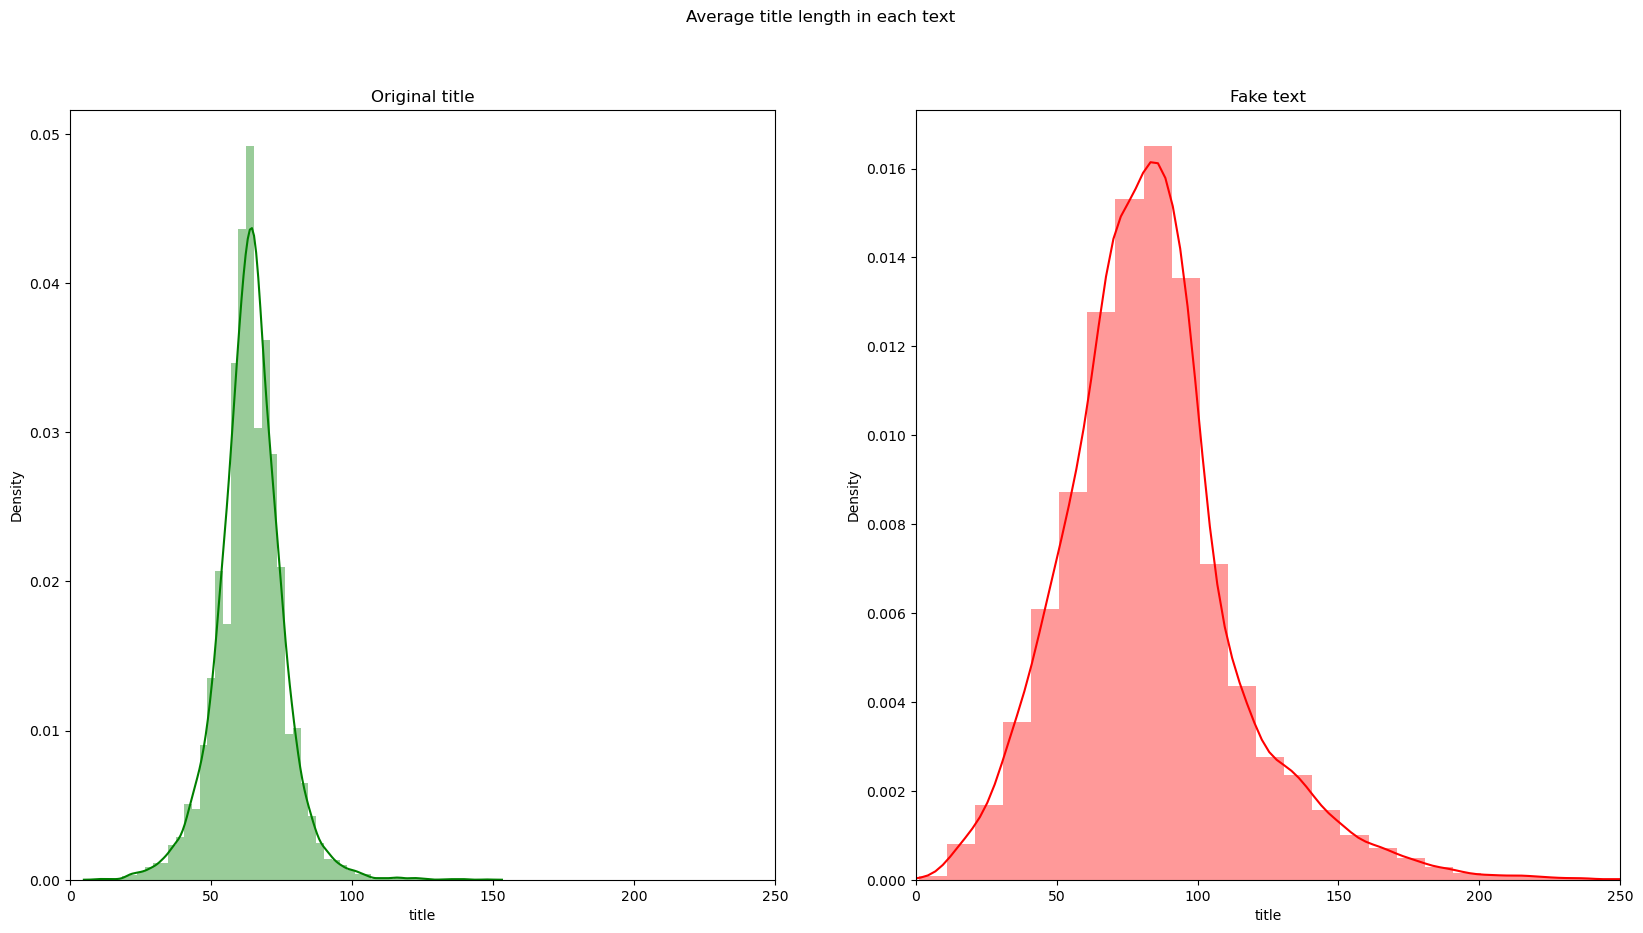

In [17]:
#average title length in each text
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))

len_word_true=df[df['label']=='true']['title'].str.len()
sns.distplot(len_word_true.map(lambda x: np.mean(x)),ax=ax1,color='green')
ax1.set_xlim([0,250])
ax1.set_title('Original title')

len_word_false=df[df['label']=='fake']['title'].str.len()
sns.distplot(len_word_false.map(lambda x: np.mean(x)),ax=ax2,color='red')
ax2.set_xlim([0,250])
ax2.set_title('Fake text')

fig.suptitle('Average title length in each text')

plt.show()

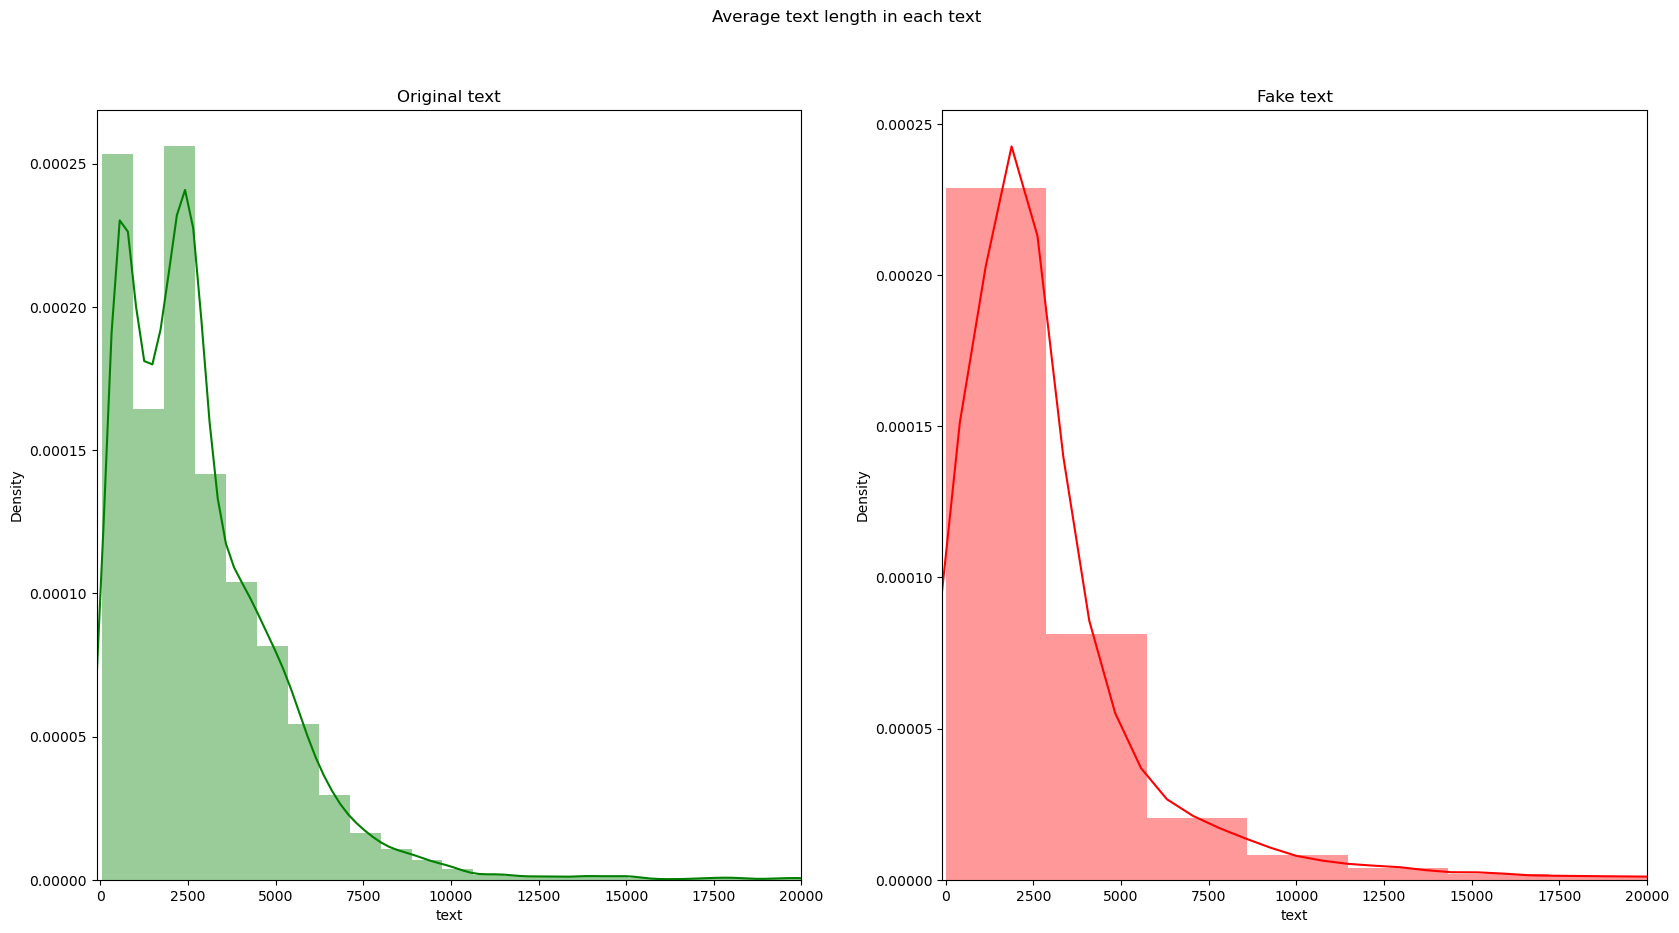

In [18]:
#average word length in each text
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
len_word_true=df[df['label']=='true']['text'].str.len()
sns.distplot(len_word_true.map(lambda x: np.mean(x)),ax=ax1,color='green')
ax1.set_title('Original text')
ax1.set_xlim([-100,20000])

len_word_false=df[df['label']=='fake']['text'].str.len()
sns.distplot(len_word_false.map(lambda x: np.mean(x)),ax=ax2,color='red')
ax2.set_title('Fake text')

fig.suptitle('Average text length in each text')
ax2.set_xlim([-100,20000])
plt.show()

In [19]:
df.loc[df['text'].isna()]

,title,text,label
2098,Live Soirée présidentielle US 2016 >> Le Gorafi,NaN,fake
30218,Des millions d’Américains recherchent massivem...,NaN,fake
38237,Trop essoufflé après avoir cherché ses affaire...,NaN,fake
16401,Des traces de vin rouge détectées dans le Beau...,NaN,fake
46803,"Heureux et souriant, il a la chance de toujour...",NaN,fake
29647,"10/6: HBD Eddie, Tom, Gene, Jeff, Joel & Radha...",NaN,fake
27689,La voyante lisait l’avenir dans les cartes ble...,NaN,fake
15872,SPA : Enfermé depuis trois jours dans une cage...,NaN,fake
47324,La Trump Tower cambriolée – les voleurs seraie...,NaN,fake
22446,Donald Trump en 5 dates >> Le Gorafi,NaN,fake


In [20]:
df.loc[df['title'].isna()]

,title,text,label
50700,NaN,Shock!!!! Hasn't this been in the news for yea...,fake
47562,NaN,"Except, of course, other US weaponry.\r\nWhere...",fake
3639,NaN,Makes sense… You do the same with any other co...,fake
18380,NaN,The second video (bottom one ) proves what Tru...,fake
49674,NaN,Evan Bayh is an excellent example....got into ...,fake
...,...,...,...
57930,NaN,"Lying, arrogant Muslim, Marxist piece of dogsh*t.",fake
30910,NaN,Another suggestion would have an independent m...,fake
23445,NaN,TPP - Remember when after TP you just washed y...,fake
13435,NaN,Your hyperbole makes you sound more like a Tru...,fake


# 3. Preprocessing

# 3.0 SPLITTING DATA

In [21]:
#splitting the data
x_train, x_test, y_train, y_test = train_test_split(df[['title','text']], df['label'], test_size=0.3, random_state=10) 
# a co zeby zrobic warstwowe probkowanie i zachowac stosunek?

In [22]:
x_train.head()

,title,text
36949,Light aircraft crash kills 11 in Tanzania,DAR ES SALAAM (Reuters) - At least 11 people w...
25622,PreseasonBlackhawks at Boston4-2 Loss Recap,PreseasonBlackhawks at Boston4-2 Loss Recap\r\...
19856,Will the anti-Clinton revolt among American el...,Will the anti-Clinton revolt among American el...
99,Mom Produces Decorative Gift Bag Out Of Thin A...,Report: Friend Has Been Going By Middle Name T...
29770,U.S. says troubled by reports of another U.S. ...,WASHINGTON (Reuters) - The United States is tr...


In [23]:
y_train.head()

36949    true
25622    fake
19856    fake
99       fake
29770    true
Name: label, dtype: object

# 3.1 Preprocessing and Text Mining 

In [24]:
stopwor = stopwords.words('English')

In [25]:
def preprocess_text(text):
    
    #lowercase text
    text = str(text) 
    text = text.lower()
    
    #Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    #Remove stop words - English
    text = ' '.join(word for word in text.split() if word not in stopwor)
    
    #Get rid of url
    text = re.sub(r'https?://\S+', '', text)
    
    return text

In [26]:
class MyTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy() 
        X_copy['text'] = X_copy['title'] + ' ' + X_copy['text'] 
        X_copy.drop(X_copy.columns[0], axis=1, inplace=True)  
        X_copy['text'] = X_copy['text'].apply(preprocess_text)  
        return X_copy['text']

In [27]:
pipeline = Pipeline([
    ('attr_extraction', MyTransformer()),
    ('tfidf', TfidfVectorizer())
])

In [28]:
pipeline.fit(x_train)

Pipeline(steps=[('attr_extraction', MyTransformer()),
                ('tfidf', TfidfVectorizer())])

In [29]:
x_train_tranformed = pipeline.transform(x_train)
x_test_transformed = pipeline.transform(x_test)

In [30]:
print(f'Shape of x_train_transformed: {x_train_tranformed.shape}')
print(f'Shape of x_test_transformed: {x_test_transformed.shape}')

Shape of x_train_transformed: (24165, 211264)
Shape of x_test_transformed: (10357, 211264)


In [31]:
label_encoder = LabelEncoder().fit(y_train)

In [32]:
y_train_transformed = label_encoder.transform(y_train)
y_test_transformed = label_encoder.transform(y_test)

In [33]:
print(f'Shape of y_train_transformed: {y_train_transformed.shape}')
print(f'Shape of y_test_transformed: {y_test_transformed.shape}')

Shape of y_train_transformed: (24165,)
Shape of y_test_transformed: (10357,)


In [34]:
# STEMMING - Sprawia ze slowa sa w bazowej formie -> dlugo trwa

#SnowballStemmer(language='english')
#stemmer = PorterStemmer()
#Stem words
#words = text.split()
#stemmed_words = [stemmer.stem(word) for word in words]
#text = ' '.join(stemmed_words)

# 3.2 PCA - Redukcja wymiarów

In [47]:
from sklearn.decomposition import TruncatedSVD

In [48]:
pca=TruncatedSVD(n_components=100)

In [50]:
pca_x_train=pca.fit_transform(x_train_tranformed)

In [53]:
pca_x_test=pca.transform(x_test_transformed)

# 4. Uczenie modelu

# 4.1 DecisionTree

In [35]:
x_train_tranformed.shape

(24165, 211264)

In [36]:
y_train_transformed.shape

(24165,)

In [37]:
DT = DecisionTreeClassifier()
DT.fit(x_train_tranformed, y_train_transformed)

DecisionTreeClassifier()

In [38]:
DT.score(x_train_tranformed, y_train_transformed)

0.999793089178564

In [39]:
DT.score(x_test_transformed, y_test_transformed)

0.9383991503331081

In [40]:
#XD
y_pred = DT.predict(x_test_transformed)
confusion_mat = confusion_matrix(y_test_transformed, y_pred)

In [41]:
print(confusion_mat)

[[6068  296]
 [ 342 3651]]


**Testowanie opłacalności algorytmu PCA**

In [54]:
DT2=DecisionTreeClassifier()
DT2.fit(pca_x_train, y_train)

DecisionTreeClassifier()

In [55]:
DT2.score(pca_x_test,y_test)

0.8575842425412764

In [56]:
DT2.score(pca_x_train,y_train)

0.999793089178564

# 4.2 RandomForest

In [42]:
rf = RandomForestClassifier()
rf.fit(x_train_tranformed, y_train_transformed)

RandomForestClassifier()

In [43]:
rf.score(x_train_tranformed, y_train_transformed)

0.999793089178564

In [44]:
rf.score(x_test_transformed, y_test_transformed)

0.9351163464323646

In [45]:
y_pred = rf.predict(x_test_transformed)
confusion_mat = confusion_matrix(y_test_transformed, y_pred)
print(confusion_mat)

[[6201  163]
 [ 509 3484]]


In [46]:
?RandomForestClassifier